In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import seaborn as sns
from sklearn.model_selection import KFold,cross_val_score
from scipy.stats import norm
from scipy import stats


%matplotlib inline


In [2]:
data=pd.read_csv("AmesHousing.tsv",delimiter="\t")

In [3]:
#descriptive statistics summary
data['SalePrice'].describe()

count      2930.000000
mean     180796.060068
std       79886.692357
min       12789.000000
25%      129500.000000
50%      160000.000000
75%      213500.000000
max      755000.000000
Name: SalePrice, dtype: float64

Minimum Sale Price > 0

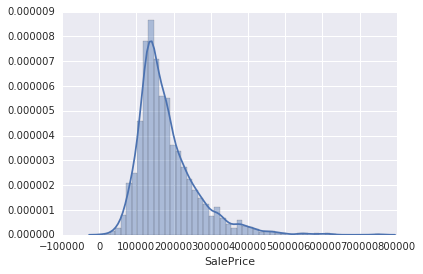

In [4]:
#histogram
sns.distplot(data['SalePrice']);

The plot:
-  Deviates from the normal distribution.
-  Has appreciable positive skewness.
-  Shows peakedness.

In [5]:
#skewness and kurtosis
print("Skewness: %f" % data['SalePrice'].skew())
print("Kurtosis: %f" % data['SalePrice'].kurt())

Skewness: 1.743500
Kurtosis: 5.118900


In [9]:
def transform_features(data):
    return data

In [10]:
def select_features(data):
    return data[["Gr Liv Area","SalePrice"]]

In [11]:
def train_and_test(data):
    train=data[:1460]
    test=data[1460:]
    lr=LinearRegression()
    
    numerical_train=train.select_dtypes(["float","int"])
    numerical_test=test.select_dtypes(["float","int"])
    
    features=numerical_train.columns.drop("SalePrice")

    lr.fit(train[features],train["SalePrice"])
    prediction=lr.predict(test[features])
    rmse=np.sqrt(mean_squared_error(test["SalePrice"],prediction))
    return rmse 

transform_df = transform_features(data)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df)

rmse

57088.251612639091

# Feature Engineering

__Handle missing values__:
-  __All columns__:
    -  Drop any with 5% or more missing values for now.
-  __Text columns__:
    -  Drop any with 1 or more missing values for now.
-  __Numerical columns__:
    -  For columns with missing values, fill in with the most common value in that column

In [12]:
missing_value=data.isnull().sum()

__All columns__

In [13]:
remove_data=missing_value[(missing_value > len(data)/20) ].sort_values()

data=data.drop(remove_data.index,axis=1)

__Text Columns__

In [14]:
text_cols=data.select_dtypes(['object'])
text_cols=text_cols.isnull().sum().sort_values(ascending=False)
remove_text_data=text_cols[text_cols > 0]

data=data.drop(remove_text_data.index,axis=1)

__Numerical Columns__

In [15]:
numerical_cols=data.select_dtypes(['float','int']).isnull().sum()
numerical_cols_to_fix=numerical_cols[(numerical_cols<len(data)/20) & (numerical_cols>0)].sort_values()
numerical_cols_to_fix

BsmtFin SF 1       1
BsmtFin SF 2       1
Bsmt Unf SF        1
Total Bsmt SF      1
Garage Cars        1
Garage Area        1
Bsmt Full Bath     2
Bsmt Half Bath     2
Mas Vnr Area      23
dtype: int64

In [16]:
#find mode of all columns
mode_values=data[numerical_cols_to_fix.index].mode().to_dict('records')[0]
mode_values

{'Bsmt Full Bath': 0.0,
 'Bsmt Half Bath': 0.0,
 'Bsmt Unf SF': 0.0,
 'BsmtFin SF 1': 0.0,
 'BsmtFin SF 2': 0.0,
 'Garage Area': 0.0,
 'Garage Cars': 2.0,
 'Mas Vnr Area': 0.0,
 'Total Bsmt SF': 0.0}

In [17]:
#fill the missing values in the columns with their mode values
data=data.fillna(mode_values)

In [18]:
data[numerical_cols_to_fix.index].isnull().sum()

BsmtFin SF 1      0
BsmtFin SF 2      0
Bsmt Unf SF       0
Total Bsmt SF     0
Garage Cars       0
Garage Area       0
Bsmt Full Bath    0
Bsmt Half Bath    0
Mas Vnr Area      0
dtype: int64

All the missing values in numerical cols are taken care of. 

What new features can we create, that better capture the information in some of the features?

In [19]:
data.dtypes

Order                int64
PID                  int64
MS SubClass          int64
MS Zoning           object
Lot Area             int64
Street              object
Lot Shape           object
Land Contour        object
Utilities           object
Lot Config          object
Land Slope          object
Neighborhood        object
Condition 1         object
Condition 2         object
Bldg Type           object
House Style         object
Overall Qual         int64
Overall Cond         int64
Year Built           int64
Year Remod/Add       int64
Roof Style          object
Roof Matl           object
Exterior 1st        object
Exterior 2nd        object
Mas Vnr Area       float64
Exter Qual          object
Exter Cond          object
Foundation          object
BsmtFin SF 1       float64
BsmtFin SF 2       float64
                    ...   
Central Air         object
1st Flr SF           int64
2nd Flr SF           int64
Low Qual Fin SF      int64
Gr Liv Area          int64
Bsmt Full Bath     float64
B

In [20]:
years_since_remod=data["Yr Sold"]-data["Year Remod/Add"]      
years_since_remod[years_since_remod<0]

1702   -1
2180   -2
2181   -1
dtype: int64

In [21]:
years_sale=data["Yr Sold"]-data["Year Built"]      
years_sale[years_sale<0]

2180   -1
dtype: int64

In [22]:
data=data.drop([1702,2180,2181],axis=0)
data=data.drop(["Year Built","Year Remod/Add"],axis=1)

data["Years Before Sale"]=years_sale
data["Years Since Remod"]=years_since_remod

Columns aren't useful for machine learning: PID , Order
Columns leak data about the final sale: Sale Condition, Sale Type (Nominal), Mo Sold , Yr Sold (Discrete)

In [23]:
data=data.drop(["PID" , "Order","Sale Condition", "Sale Type", "Mo Sold", "Yr Sold"],axis=1)


In [24]:
data.head()

,MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,...,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,SalePrice,Years Before Sale,Years Since Remod
0,20,RL,31770,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,...,210,62,0,0,0,0,0,215000,50,50
1,20,RH,11622,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,...,140,0,0,0,120,0,0,105000,49,49
2,20,RL,14267,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,...,393,36,0,0,0,0,12500,172000,52,52
3,20,RL,11160,Pave,Reg,Lvl,AllPub,Corner,Gtl,NAmes,...,0,0,0,0,0,0,0,244000,42,42
4,60,RL,13830,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,...,212,34,0,0,0,0,0,189900,13,12


In [25]:
#combining all the above steps in transform_features

def select_features(df):
    return df[["Gr Liv Area", "SalePrice"]]

def transform_features(data):
    temp = data
    
    missing_value=temp.isnull().sum()
    remove_data=missing_value[(missing_value > len(data)/20) ].sort_values()
    temp=temp.drop(remove_data.index,axis=1)
    
    text_cols=temp.select_dtypes(['object'])
    text_cols=text_cols.isnull().sum().sort_values(ascending=False)
    remove_text_data=text_cols[text_cols > 0]
    temp=temp.drop(remove_text_data.index,axis=1)
    
    numerical_cols=data.select_dtypes(['float','int']).isnull().sum()
    numerical_cols_to_fix=numerical_cols[(numerical_cols<len(data)/20) & (numerical_cols>0)].sort_values()
    
    #find mode of all columns
    mode_values=temp[numerical_cols_to_fix.index].mode().to_dict('records')[0]
    #fill the missing values in the columns with their mode values
    temp=temp.fillna(mode_values)
    
    years_sale=temp["Yr Sold"]-temp["Year Built"] 
    temp=temp.drop([1702,2180,2181],axis=0)
    temp=temp.drop(["Year Built","Year Remod/Add"],axis=1)

    temp["Years Before Sale"]=years_sale
    temp["Years Since Remod"]=years_since_remod
    
    temp=temp.drop(["PID" , "Order","Sale Condition", "Sale Type", "Mo Sold", "Yr Sold"],axis=1)
    
    return temp

def train_and_test(data):
    train=data[:1460]
    test=data[1460:]
    lr=LinearRegression()
    
    numerical_train=train.select_dtypes(["float","int"])
    numerical_test=test.select_dtypes(["float","int"])
    
    features=numerical_train.columns.drop("SalePrice")

    lr.fit(train[features],train["SalePrice"])
    prediction=lr.predict(test[features])
    rmse=np.sqrt(mean_squared_error(test["SalePrice"],prediction))
    return rmse 

data = pd.read_csv("AmesHousing.tsv", delimiter="\t")
transform_df = transform_features(data)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df)

rmse

    

55275.367312413073

rmse Value Change: 57088.251612639091 to 55275.367312413073


__Feature selection__ for numerical features

In [26]:
numerical_features=transform_df.select_dtypes(['float','int'])
numerical_features

,MS SubClass,Lot Area,Overall Qual,Overall Cond,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,...,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,SalePrice,Years Before Sale,Years Since Remod
0,20,31770,6,5,112.0,639.0,0.0,441.0,1080.0,1656,...,210,62,0,0,0,0,0,215000,50,50
1,20,11622,5,6,0.0,468.0,144.0,270.0,882.0,896,...,140,0,0,0,120,0,0,105000,49,49
2,20,14267,6,6,108.0,923.0,0.0,406.0,1329.0,1329,...,393,36,0,0,0,0,12500,172000,52,52
3,20,11160,7,5,0.0,1065.0,0.0,1045.0,2110.0,2110,...,0,0,0,0,0,0,0,244000,42,42
4,60,13830,5,5,0.0,791.0,0.0,137.0,928.0,928,...,212,34,0,0,0,0,0,189900,13,12
5,60,9978,6,6,20.0,602.0,0.0,324.0,926.0,926,...,360,36,0,0,0,0,0,195500,12,12
6,120,4920,8,5,0.0,616.0,0.0,722.0,1338.0,1338,...,0,0,170,0,0,0,0,213500,9,9
7,120,5005,8,5,0.0,263.0,0.0,1017.0,1280.0,1280,...,0,82,0,0,144,0,0,191500,18,18
8,120,5389,8,5,0.0,1180.0,0.0,415.0,1595.0,1616,...,237,152,0,0,0,0,0,236500,15,14
9,60,7500,7,5,0.0,0.0,0.0,994.0,994.0,1028,...,140,60,0,0,0,0,0,189000,11,11


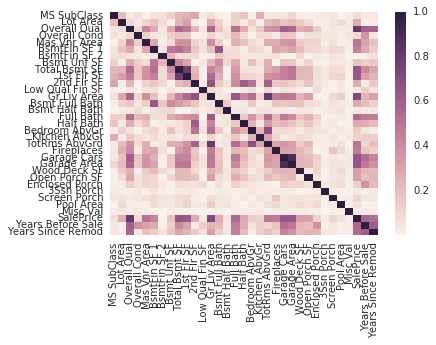

In [27]:
corr=transform_df[numerical_features.columns].corr().abs()
sns.heatmap(corr)  

In [28]:
#corr on numerical features
sorted_features=numerical_features.corr().abs()["SalePrice"]
sorted_features

MS SubClass          0.085128
Lot Area             0.267520
Overall Qual         0.801206
Overall Cond         0.101540
Mas Vnr Area         0.506983
BsmtFin SF 1         0.439284
BsmtFin SF 2         0.006127
Bsmt Unf SF          0.182751
Total Bsmt SF        0.644012
1st Flr SF           0.635185
2nd Flr SF           0.269601
Low Qual Fin SF      0.037629
Gr Liv Area          0.717596
Bsmt Full Bath       0.276258
Bsmt Half Bath       0.035875
Full Bath            0.546118
Half Bath            0.284871
Bedroom AbvGr        0.143916
Kitchen AbvGr        0.119760
TotRms AbvGrd        0.498574
Fireplaces           0.474831
Garage Cars          0.648361
Garage Area          0.641425
Wood Deck SF         0.328183
Open Porch SF        0.316262
Enclosed Porch       0.128685
3Ssn Porch           0.032268
Screen Porch         0.112280
Pool Area            0.068438
Misc Val             0.019273
SalePrice            1.000000
Years Before Sale    0.558979
Years Since Remod    0.534985
Name: Sale

In [29]:
#features less than 0.4 corr is removed
less_than_threshold=sorted_features[sorted_features < 0.4]
less_than_threshold

MS SubClass        0.085128
Lot Area           0.267520
Overall Cond       0.101540
BsmtFin SF 2       0.006127
Bsmt Unf SF        0.182751
2nd Flr SF         0.269601
Low Qual Fin SF    0.037629
Bsmt Full Bath     0.276258
Bsmt Half Bath     0.035875
Half Bath          0.284871
Bedroom AbvGr      0.143916
Kitchen AbvGr      0.119760
Wood Deck SF       0.328183
Open Porch SF      0.316262
Enclosed Porch     0.128685
3Ssn Porch         0.032268
Screen Porch       0.112280
Pool Area          0.068438
Misc Val           0.019273
Name: SalePrice, dtype: float64

In [30]:
transform_df = transform_df.drop(sorted_features[sorted_features < 0.4].index, axis=1)
transform_df

,MS Zoning,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,...,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Garage Cars,Garage Area,Paved Drive,SalePrice,Years Before Sale,Years Since Remod
0,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,...,TA,7,Typ,2,2.0,528.0,P,215000,50,50
1,RH,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,...,TA,5,Typ,0,1.0,730.0,Y,105000,49,49
2,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,...,Gd,6,Typ,0,1.0,312.0,Y,172000,52,52
3,RL,Pave,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,...,Ex,8,Typ,2,2.0,522.0,Y,244000,42,42
4,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,...,TA,6,Typ,1,2.0,482.0,Y,189900,13,12
5,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,...,Gd,7,Typ,1,2.0,470.0,Y,195500,12,12
6,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,StoneBr,Norm,Norm,...,Gd,6,Typ,0,2.0,582.0,Y,213500,9,9
7,RL,Pave,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,...,Gd,5,Typ,0,2.0,506.0,Y,191500,18,18
8,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,StoneBr,Norm,Norm,...,Gd,5,Typ,1,2.0,608.0,Y,236500,15,14
9,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,...,Gd,7,Typ,1,2.0,442.0,Y,189000,11,11


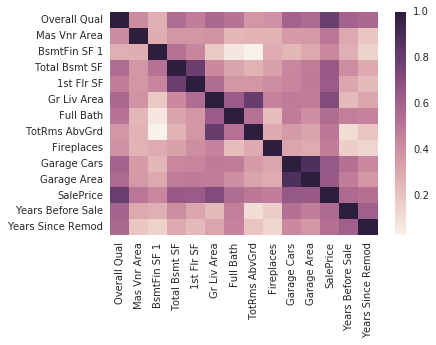

In [31]:
corr=transform_df.corr().abs()
sns.heatmap(corr)  

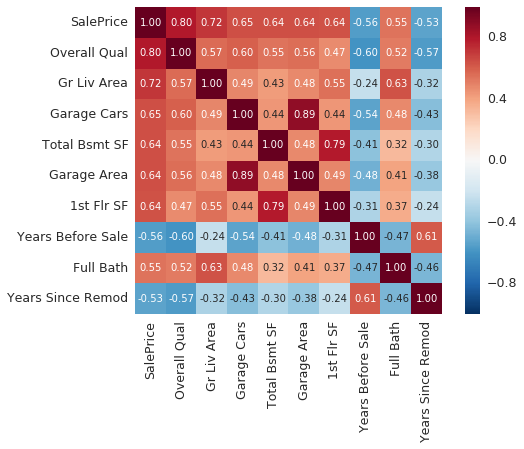

In [40]:
#More informative heatmap by selecting top 10 features

k = 10 #number of variables for heatmap
cols = corr.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(transform_df[cols].values.T)
sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

-  GR Liv Area, Total Bsmt SF and Overall Qual __strongly correlate__ with SalePrice (Target)
-  Garage Cars and Garage Area also strongly correlate with Sale Price.
   But both of them are related. Larger Garage area tends to larger no.of cars in garage.
   So we can remove one of them.
   We will keep Garage Area since its continuous while the other is dicrete
-  TotalBsmtSF and 1stFloor are also alike.
   TotalBsmtSF is Total square feet of basement area
   1stFloor is First Floor Square Feet
   So we can remove one. Lets keep Total Bsmt SF
-  FullBath is also not really important

# Relation with Numerical Features

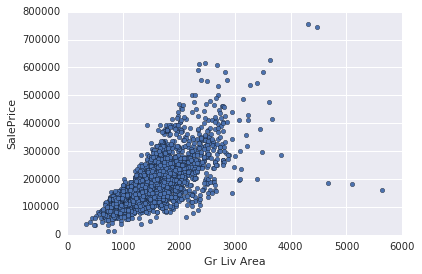

In [6]:
#scatter plot grlivarea/saleprice
data.plot.scatter(x='Gr Liv Area', y='SalePrice', ylim=(0,800000));

Very strong correlation and a __linear relation__

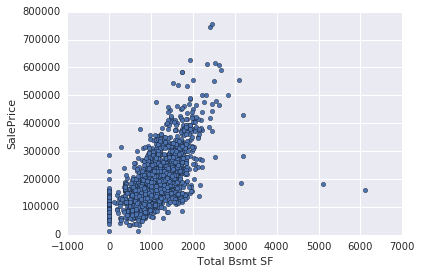

In [7]:
data.plot.scatter(x='Total Bsmt SF', y='SalePrice', ylim=(0,800000));

Strong correlation and  __exponential relation__

### Scatter plots between 'SalePrice' and correlated variables 

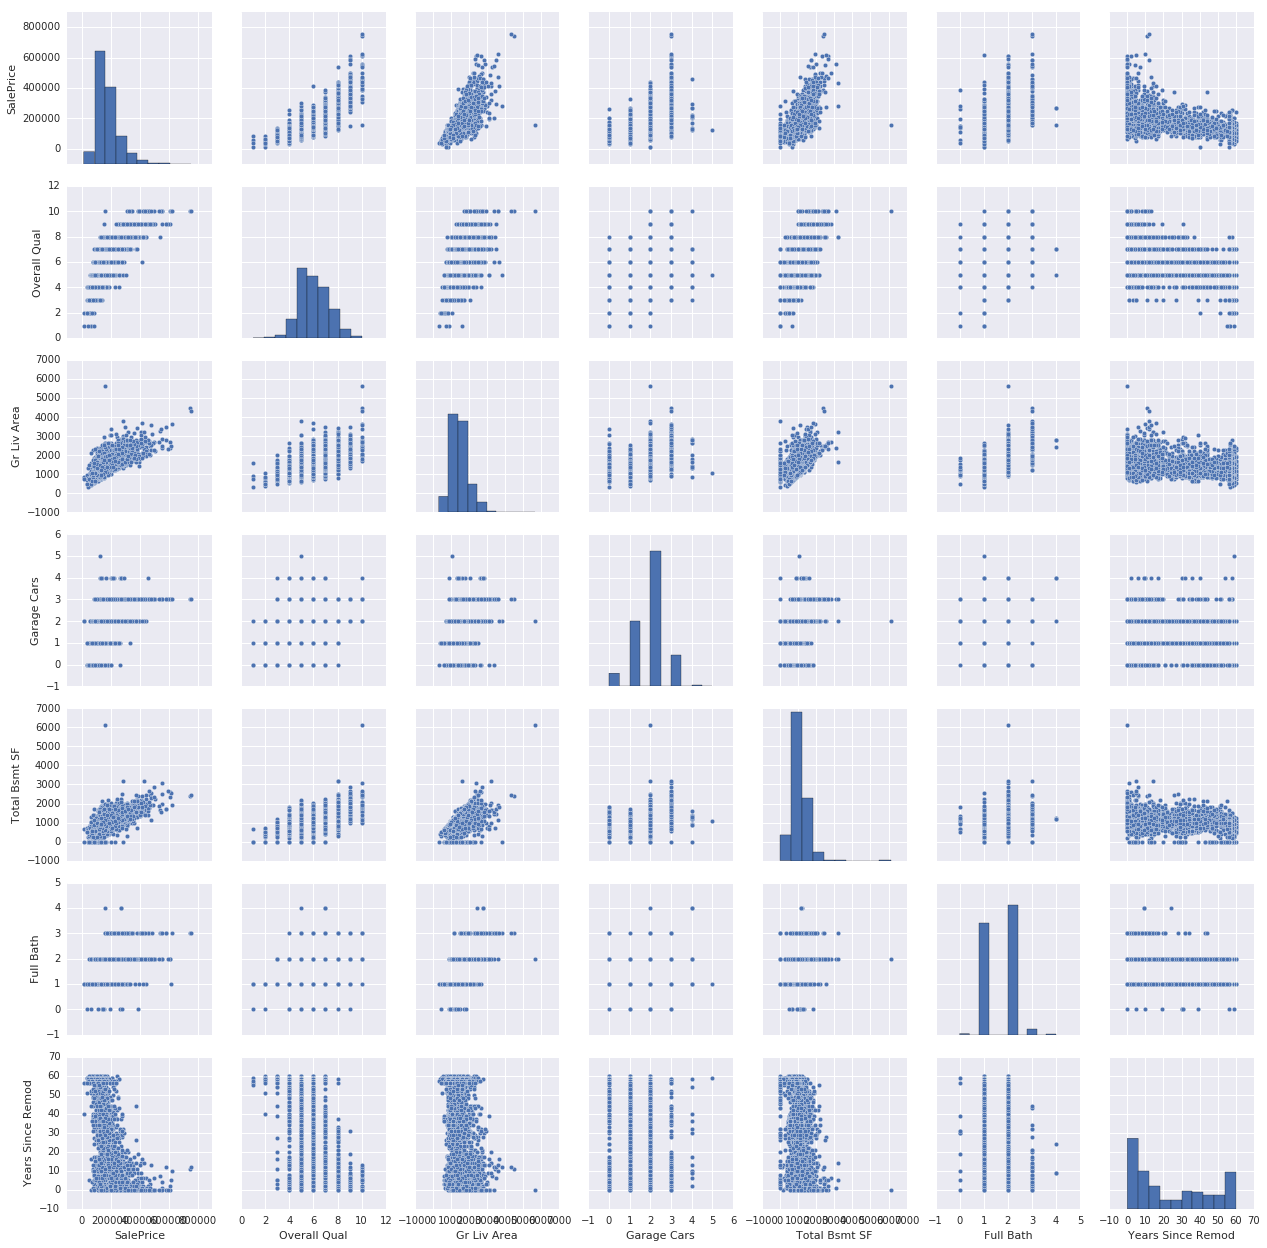

In [50]:
sns.set()
cols = ['SalePrice', 'Overall Qual', 'Gr Liv Area', 'Garage Cars', 'Total Bsmt SF', 'Full Bath', 'Years Since Remod']
sns.pairplot(transform_df[cols],size=2.5)
plt.show()

__TotalBsmtSF and GrLiveArea__.
In this figure we can see the dots drawing a linear line, which almost acts like a border. It totally makes sense that the majority of the dots stay below that line. Basement areas can be equal to the above ground living area, but it is not expected a basement area bigger than the above ground living area.


In [ ]:
transform_df.dtypes

# Relation With Categorical Features

Which columns in the data frame should be converted to the categorical data type?

In [ ]:
#a list of column names from documentation that are *meant* to be categorical
nominal_features=["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]

len(nominal_features)

In [ ]:
## Which categorical columns have we still carried with us?  
transform_cat_cols = []
for c in nominal_features:
    if c in transform_df.columns:
        transform_cat_cols.append(c)
        

In [ ]:
uniqueness_counts = transform_df[transform_cat_cols].apply(lambda col: len(col.value_counts())).sort_values()
uniqueness_counts

In [ ]:
## How many unique values in each categorical column?
unique_count={}
for i in transform_cat_cols:
    count=len(transform_df[i].value_counts())
    unique_count[i]=count
              
unique_count=pd.Series(unique_count).sort_values()
unique_count

In [ ]:
non_unique_count=unique_count[unique_count > 10].index
non_unique_count

In [ ]:
transform_df=transform_df.drop(['Exterior 1st', 'Exterior 2nd', 'Neighborhood'],axis=1)

In [ ]:
#Now convert the rest text type col to categorical type and then dummy 

text_cols = transform_df.select_dtypes(include=['object'])

for col in text_cols:
    transform_df[col]=transform_df[col].astype("category")
    
dummy_cols=pd.DataFrame()
for col in text_cols:
    dummy=pd.get_dummies(transform_df[col])
    transform_df=pd.concat([transform_df,dummy],axis=1)
    del transform_df[col]

    

In [ ]:
potential_category_numerical_cols=['Overall Qual','Overall Cond','MS SubClass']

for col in potential_category_numerical_cols:
    transform_df[col]=transform_df[col].astype("category")
    
dummy_cols=pd.DataFrame()

for col in potential_category_numerical_cols:
    dummy=pd.get_dummies(transform_df[col])
    transform_df=pd.concat([transform_df,dummy],axis=1)
    del transform_df[col]


Doubt->

['Overall Qual','Overall Cond','MS SubClass']
These are potential Numerical columns that can be category type.
But when we try to convert it to category type  then the rmse value becomes 40400.11 (something like this)
That is an increase from 36623.535629104757 after feature selection more correlated columns and object to category conversion.
Why is that? 

### Update select_features()

In [98]:

def select_features(df,corr_threshold=0.4,unique_threshold=10):
    
    transform_df=df
    
    numerical_features=transform_df.select_dtypes(['float','int'])
    sorted_features=numerical_features.corr().abs()["SalePrice"]
    less_than_threshold=sorted_features[sorted_features < corr_threshold]
    transform_df = transform_df.drop(less_than_threshold.index, axis=1)
    
    nominal_features=["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]

    
    transform_cat_cols = []
    for c in nominal_features:
        if c in transform_df.columns:
            transform_cat_cols.append(c)
            
    uniqueness_counts = transform_df[transform_cat_cols].apply(lambda col: len(col.value_counts())).sort_values()
    non_unique_count= uniqueness_counts[uniqueness_counts > unique_threshold].index
    transform_df=transform_df.drop(non_unique_count,axis=1)
    
    text_cols = transform_df.select_dtypes(include=['object'])

    for col in text_cols:
        transform_df[col]=transform_df[col].astype("category")
        
    

    
    dummy_cols=pd.DataFrame()
    for col in text_cols:
        dummy=pd.get_dummies(transform_df[col])
        transform_df=pd.concat([transform_df,dummy],axis=1)
        del transform_df[col]
        
    return transform_df

#NO CHANGE
def transform_features(df):
    num_missing = df.isnull().sum()
    drop_missing_cols = num_missing[(num_missing > len(df)/20)].sort_values()
    df = df.drop(drop_missing_cols.index, axis=1)
    
    text_mv_counts = df.select_dtypes(include=['object']).isnull().sum().sort_values(ascending=False)
    drop_missing_cols_2 = text_mv_counts[text_mv_counts > 0]
    df = df.drop(drop_missing_cols_2.index, axis=1)
    
    num_missing = df.select_dtypes(include=['int', 'float']).isnull().sum()
    fixable_numeric_cols = num_missing[(num_missing < len(df)/20) & (num_missing > 0)].sort_values()
    replacement_values_dict = df[fixable_numeric_cols.index].mode().to_dict(orient='records')[0]
    df = df.fillna(replacement_values_dict)
    
    years_sold = df['Yr Sold'] - df['Year Built']
    years_since_remod = df['Yr Sold'] - df['Year Remod/Add']
    df['Years Before Sale'] = years_sold
    df['Years Since Remod'] = years_since_remod
    df = df.drop([1702, 2180, 2181], axis=0)

    df = df.drop(["PID", "Order", "Mo Sold", "Sale Condition", "Sale Type", "Year Built", "Year Remod/Add"], axis=1)
    return df


def train_and_test(data):
    train=data[:1460]
    test=data[1460:]
    lr=LinearRegression()
    
    numerical_train=train.select_dtypes(["float","int"])
    numerical_test=test.select_dtypes(["float","int"])
    
    features=numerical_train.columns.drop("SalePrice")

    lr.fit(train[features],train["SalePrice"])
    prediction=lr.predict(test[features])
    rmse=np.sqrt(mean_squared_error(test["SalePrice"],prediction))
    return rmse 


data = pd.read_csv("AmesHousing.tsv", delimiter="\t")

transform_df = transform_features(data)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df)

rmse


36623.535629104757

After __feature selection__ rmse value changed from 

55275.367312413073 to 36623.535629104757 

In [103]:
remaining_category_cols=['MS Zoning', 'Street', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Condition 1', 'Condition 2', 'Bldg Type',
       'House Style', 'Roof Style', 'Roof Matl', 'Exter Qual', 'Exter Cond',
       'Foundation', 'Heating', 'Heating QC', 'Central Air', 'Kitchen Qual',
       'Functional', 'Paved Drive']


In [77]:
#Overall Qual is a numerical column but it should be category type.

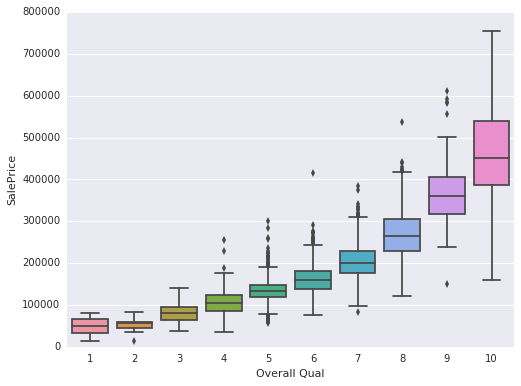

In [8]:
#box plot overallqual/saleprice
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x="Overall Qual", y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

'Overall Qual' seems to be related with 'SalePrice'. The relationship seems to be strong where the _box plot shows how sales prices increase with the overall quality._

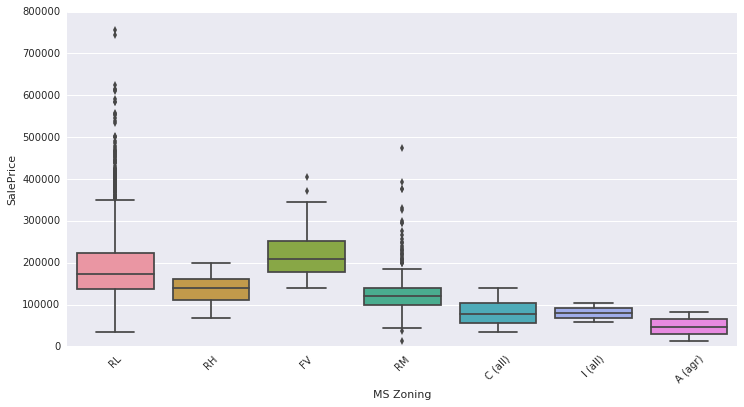

In [104]:
#MS Zoning and SalePrice
plt.figure(figsize = (12, 6))
sns.boxplot(x = 'MS Zoning', y = 'SalePrice',  data = transform_df)
xt = plt.xticks(rotation=45)

Update test_and _train() by adding a parameter named k that controls the type of cross validation that occurs.

In [ ]:
def train_and_test(df,k=0):
    
    
    numerical_features=df.select_dtypes(["float","int"])
    features=numerical_features.columns.drop("SalePrice")
    lr=LinearRegression()

    if k==0:
        #perform holdout validation
        train=df[:1460]
        test=df[1460:]
        
        lr.fit(train[features],train["SalePrice"])
        prediction=lr.predict(test[features])
        
        rmse=np.sqrt(mean_squared_error(test["SalePrice"],prediction))
        return rmse 
    
    if k==1:
        #shuffle the ordering
        np.random.seed(1)
        shuffled_index=np.random.permutation(df.index)
        df=df.reindex(shuffled_index)
        
        #perform simple cross validation
        fold_one=df[:1460]
        fold_two=df[1460:]
        
        #Train on fold_one and test on fold_two
        lr.fit(fold_one[features],fold_one["SalePrice"])
        prediction=lr.predict(fold_two[features])
        rmse_1=np.sqrt(mean_squared_error(fold_two["SalePrice"],prediction))
        
        #Train on fold_two and test on fold_one
        lr.fit(fold_two[features],fold_two["SalePrice"])
        prediction=lr.predict(fold_one[features])
        rmse_2=np.sqrt(mean_squared_error(fold_one["SalePrice"],prediction))
        
        avg_rmse=np.mean(rmse_1,rmse_2)
        return avg_rmse
    
    else:
        
        #k-fold cross validation using k folds
        kf=KFold(k,shuffle=True,random_state=1)
        rmses=np.sqrt(np.absolute((cross_val_score(lr,
                                      df[features],
                                      df[["SalePrice"]],
                                      scoring="neg_mean_squared_error",
                                      cv=kf))))
       
        avg_rmse=np.mean(rmses)
        print(rmses)
        return avg_rmse
        
        '''
        #k-fold cross validation using k folds
        kf = KFold(n_splits=k, shuffle=True,random_state=1)
        rmses=[]
        for train_index,test_index in kf.split(df):
            train=df.iloc[train_index]
            test=df.iloc[test_index]
            
            lr.fit(train[features],train["SalePrice"])
            prediction=lr.predict(test[features])
        
            rmse=np.sqrt(mean_squared_error(test["SalePrice"],prediction))
            rmses.append(rmse)
            print(rmse)
        
        return np.mean(rmses)
        '''

        
    
df = pd.read_csv("AmesHousing.tsv", delimiter="\t")
transform_df = transform_features(df)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df, k=4)

rmse
        
        
    
    

After __updating train_test() __ rmse value changed from 

36623.535629104757 to 32740.932204622295


#### Normality of plot

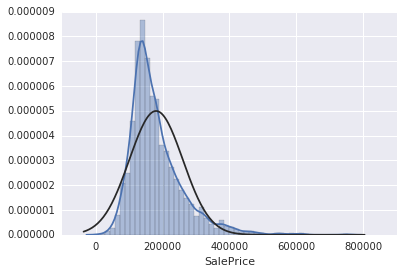

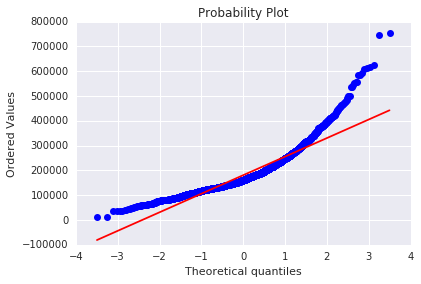

In [55]:
#histogram and normal probability plot
sns.distplot(transform_df['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(transform_df['SalePrice'], plot=plt)

SalePrice is not normal. It shows 'peakedness', positive skewness and does not follow the diagonal line.
We need to bring closer to normal form. We will use log transformation.

In [56]:
transform_df['SalePrice'] = np.log(transform_df['SalePrice'])

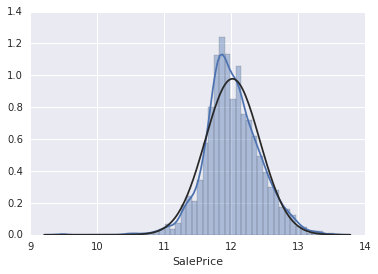

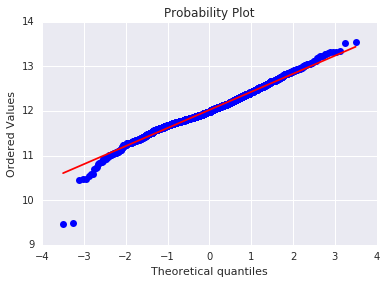

In [57]:
sns.distplot(transform_df['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(transform_df['SalePrice'], plot=plt)

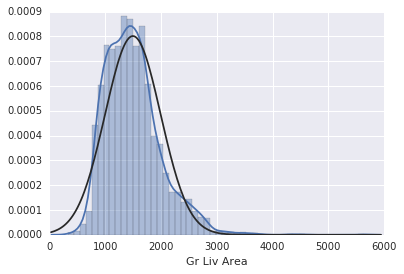

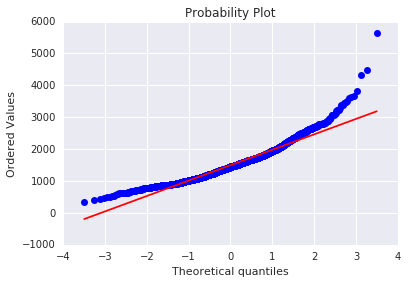

In [58]:
sns.distplot(transform_df['Gr Liv Area'], fit=norm);
fig = plt.figure()
res = stats.probplot(transform_df['Gr Liv Area'], plot=plt)

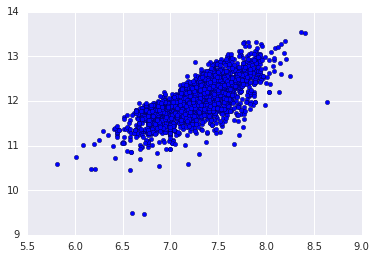

In [76]:
plt.scatter(transform_df['Gr Liv Area'], transform_df['SalePrice']);


This has changed from cone corners to this. This is because of the log function we used. This is called __homoscedasticit__.
We can say that, in general, SalePrice exhibit equal levels of variance across the range of Gr Liv Area.



In [69]:
numerical_columns=transform_df.select_dtypes(['int'])
numerical_columns.columns

Index(['MS SubClass', 'Lot Area', 'Overall Qual', 'Overall Cond', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Full Bath',
       'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd',
       'Fireplaces', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch',
       '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val', 'Yr Sold',
       'SalePrice', 'Years Before Sale', 'Years Since Remod'],
      dtype='object')

In [73]:
uniqueness_counts = transform_df[numerical_columns.columns].apply(lambda col: len(col.value_counts())).sort_values()

non_unique=uniqueness_counts[uniqueness_counts>10].index
non_unique

Half Bath               3
Kitchen AbvGr           4
Yr Sold                 5
Fireplaces              5
Full Bath               5
Bedroom AbvGr           8
Overall Cond            9
Overall Qual           10
TotRms AbvGrd          13
Pool Area              14
MS SubClass            16
3Ssn Porch             31
Low Qual Fin SF        36
Misc Val               37
Years Since Remod      61
Screen Porch          121
Years Before Sale     127
Enclosed Porch        183
Open Porch SF         249
Wood Deck SF          379
2nd Flr SF            633
SalePrice            1029
1st Flr SF           1081
Gr Liv Area          1289
Lot Area             1958
dtype: int64